In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

In [2]:
# Function to apply stain separation annotation
def separate_stains(image):
    # Convert RGB image to grayscale
    gray = rgb2gray(image)
    
    # Apply Otsu's thresholding to separate stains
    thresh = threshold_otsu(gray)
    blue_mask = gray < thresh
    
    # Multiply original image with the blue mask
    blue_stain = np.multiply(image, np.expand_dims(blue_mask, axis=-1))
    return blue_stain

In [3]:
# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [4]:
# Add a fully connected layer with softmax activation for the fibrosis classification
predictions = Dense(5, activation='softmax')(x)

# Combine the base ResNet50 model with the custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Define ImageDataGenerator for data augmentation and loading
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [6]:
# Load and augment the images using ImageDataGenerator
train_generator = datagen.flow_from_directory(
    'D:/DATASET/CNN/fibrosis/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    'D:/DATASET/CNN/fibrosis/val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

model.summary()

Found 4282 images belonging to 5 classes.
Found 1067 images belonging to 5 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
          

 ization)                       256)                                                              
                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
          

 conv3_block2_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block2_1_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_blo

                                1024)                                                             
                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
          

 conv4_block6_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block6_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_blo

In [7]:
# Train the model and save the history
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Save the model
model.save('D:/DATASET/Models/fibrosis_model.h5')


Epoch 1/10
134/134 [==============================] - 2217s 16s/step - loss: 0.9583 - accuracy: 0.7219 - val_loss: 1.0609 - val_accuracy: 0.6729
Epoch 2/10
134/134 [==============================] - 2240s 17s/step - loss: 0.6974 - accuracy: 0.7725 - val_loss: 1.0623 - val_accuracy: 0.6354
Epoch 3/10
134/134 [==============================] - 2237s 17s/step - loss: 0.5975 - accuracy: 0.7924 - val_loss: 1.7228 - val_accuracy: 0.5089
Epoch 4/10
134/134 [==============================] - 2582s 19s/step - loss: 0.5643 - accuracy: 0.7989 - val_loss: 12.8461 - val_accuracy: 0.2530
Epoch 5/10
134/134 [==============================] - 2422s 18s/step - loss: 0.5708 - accuracy: 0.8001 - val_loss: 4.3427 - val_accuracy: 0.5333
Epoch 6/10
134/134 [==============================] - 2091s 16s/step - loss: 0.5588 - accuracy: 0.8139 - val_loss: 8.2450 - val_accuracy: 0.5539
Epoch 7/10
134/134 [==============================] - 2031s 15s/step - loss: 0.4292 - accuracy: 0.8463 - val_loss: 0.8966 - val_a

In [8]:
# Save the training history
with open('D:/DATASET/Models/fibrosis_history.json', 'w') as file:
    json.dump(history.history, file)


In [9]:
# Function to plot validation loss
def plot_validation_loss(history, model_name):
    plt.plot(history['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Validation Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()


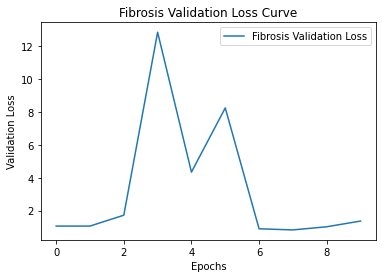

In [10]:
# Plot validation loss for fibrosis model
with open('D:/DATASET/Models/fibrosis_history.json', 'r') as file:
    fibrosis_history = json.load(file)

plot_validation_loss(fibrosis_history, 'Fibrosis')

In [ ]:
# Fine-tune the model
model.fit(train_generator, epochs=3)

# Unfreeze some layers in the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model to apply changes
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/3
 20/134 [===>..........................] - ETA: 32:15 - loss: 0.1770 - accuracy: 0.9359

In [ ]:
# Function to generate feature maps
def generate_feature_map(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Get feature maps
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_3_conv').output)
    intermediate_output = intermediate_layer_model.predict(x)
    
    # Plot the feature maps
    plt.figure(figsize=(16, 16))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
    plt.show()


In [ ]:
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Define lower and upper bounds for dark blue color in HSV
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 100])  # Adjust this upper bound as needed
    
    # Threshold the HSV image to get only dark blue colors
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    
    # Find contours of dark blue regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the area of dark blue regions and draw contours on the image
    blue_area = 0
    img_with_contours = img.copy()  # Create a copy of the original image
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)  # Draw contour on the image
    
    return blue_area, img_with_contours

# Function to make prediction on a single image
def predict_image(img_path, model):
    # Load and preprocess the image
    img = Image.open(img_path)
    #img = img.resize((299, 299))  # Resize the image
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict using the model
    preds = model.predict(x)
    print('Predictions:', preds)

    # Get the index of the class with maximum probability
    max_prob_index = np.argmax(preds)
    
    # Define the NASH score mapping
    nash_scores = {
        0: "0: No fibrosis",
        1: "1: Mild/moderate perisinusoidal fibrosis",
        2: "2: Periportal/portal fibrosis",
        3: "3: Bridging fibrosis",
        4: "4: Cirrhosis"
    }
    
    # Get the NASH score corresponding to the maximum probability
    nash_score = nash_scores[max_prob_index]
    
    # Calculate blue area and overlay contours on the image
    blue_area, img_with_contours = calculate_blue_area(np.array(img))
    print('Blue stain area:', blue_area)
    
    # Print the NASH score
    print('Predicted NASH score:', nash_score)
    
    # Display the image with blue contours
    plt.imshow(img_with_contours)
    plt.title('Image with Blue Stain Contours')
    plt.axis('off')
    plt.show()


In [ ]:
# Path to the input image
img_path = "D:/Testing (Triya ma'am)/MASSONS TRICHOME SCORING/NASH_massons trichome_40x/5.jpeg"

# Predict NASH score, calculate blue area, and display the image with blue contours
show_image(img_path)
predict_image(img_path, model)
